In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/subspaces/layer_20_halu_eval.pt
/kaggle/input/subspaces/layer_20_trivia_qa.pt
/kaggle/input/subspaces/layer_20_nq.pt
/kaggle/input/subspaces/layer_20_truthful_qa.pt


In [2]:
import torch
import numpy as np
from itertools import combinations
from scipy.linalg import svd

# Define your dataset suffixes here
datasets = ["halu_eval", "trivia_qa", "nq", "truthful_qa"]  # Replace with actual names
rsv_dict = {}

# Load the .pt files: your tensors are [k, D], so we transpose to [D, k]
for ds in datasets:
    file_path = f"/kaggle/input/subspaces/layer_20_{ds}.pt"
    tensor = torch.load(file_path)
    rsv_dict[ds] = tensor.T.cpu().numpy()  # shape: [D, k]

def compute_subspace_metrics(V_A, V_B):
    # V_A, V_B: [D, k]
    _, sigma, _ = svd(V_A.T @ V_B)  # shape: [k, k]
    sigma = np.clip(sigma, -1.0, 1.0)  # numerical safety
    theta_rad = np.arccos(sigma)       # in radians
    theta_deg = np.degrees(theta_rad)  # convert to degrees

    mean_angle = np.mean(theta_deg)
    max_angle = np.max(theta_deg)
    chordal_distance = np.sqrt(np.sum(np.sin(theta_rad) ** 2))  # stays in radians

    return {
        "mean_angle_deg": mean_angle,
        "max_angle_deg": max_angle,
        "chordal_distance": chordal_distance,
        "angles_deg": theta_deg
    }

# Pairwise comparisons
results = {}

for (ds1, ds2) in combinations(datasets, 2):
    metrics = compute_subspace_metrics(rsv_dict[ds1], rsv_dict[ds2])
    results[(ds1, ds2)] = metrics

# Print results
for (ds1, ds2), metrics in results.items():
    print(f"\n📊 Subspace Comparison: {ds1} vs {ds2}")
    print(f"Mean Angle (°):        {metrics['mean_angle_deg']:.2f}")
    print(f"Max Angle  (°):        {metrics['max_angle_deg']:.2f}")
    print(f"Chordal Distance      : {metrics['chordal_distance']:.4f}")



📊 Subspace Comparison: halu_eval vs trivia_qa
Mean Angle (°):        58.69
Max Angle  (°):        88.69
Chordal Distance      : 3.6930

📊 Subspace Comparison: halu_eval vs nq
Mean Angle (°):        55.63
Max Angle  (°):        89.34
Chordal Distance      : 3.5881

📊 Subspace Comparison: halu_eval vs truthful_qa
Mean Angle (°):        60.71
Max Angle  (°):        89.83
Chordal Distance      : 3.7805

📊 Subspace Comparison: trivia_qa vs nq
Mean Angle (°):        58.57
Max Angle  (°):        87.63
Chordal Distance      : 3.7086

📊 Subspace Comparison: trivia_qa vs truthful_qa
Mean Angle (°):        68.04
Max Angle  (°):        88.29
Chordal Distance      : 4.0453

📊 Subspace Comparison: nq vs truthful_qa
Mean Angle (°):        66.02
Max Angle  (°):        88.17
Chordal Distance      : 3.9748


In [4]:
k = 20  # Or however many basis vectors you want in the shared subspace

# Step 1: Stack all RSVs into a combined basis
all_bases = np.concatenate([rsv_dict[ds] for ds in datasets], axis=1)  # [D, 20*N]
U, S, Vh = np.linalg.svd(all_bases, full_matrices=False)
truthful_subspace = U[:, :k]  # [D, k]

# Step 2: Evaluate each dataset individually
for ds in datasets:
    dataset_rsv = rsv_dict[ds]  # This is [D, 20]

    # Principal angles
    _, sigma, _ = np.linalg.svd(dataset_rsv.T @ truthful_subspace)
    angles_deg = np.degrees(np.arccos(np.clip(sigma, -1.0, 1.0)))
    mean_angle = np.mean(angles_deg)

    # Explained energy (projection strength)
    proj = truthful_subspace @ truthful_subspace.T @ dataset_rsv
    explained_energy = (
        np.linalg.norm(proj, ord='fro')**2 /
        np.linalg.norm(dataset_rsv, ord='fro')**2
    )

    print(f"\n📊 Dataset: {ds}")
    print(f"Mean principal angle (°): {mean_angle:.2f}")
    print(f"Explained energy:         {explained_energy:.4f}")



📊 Dataset: halu_eval
Mean principal angle (°): 32.57
Explained energy:         0.6975

📊 Dataset: trivia_qa
Mean principal angle (°): 40.97
Explained energy:         0.5732

📊 Dataset: nq
Mean principal angle (°): 36.50
Explained energy:         0.6430

📊 Dataset: truthful_qa
Mean principal angle (°): 46.54
Explained energy:         0.4861


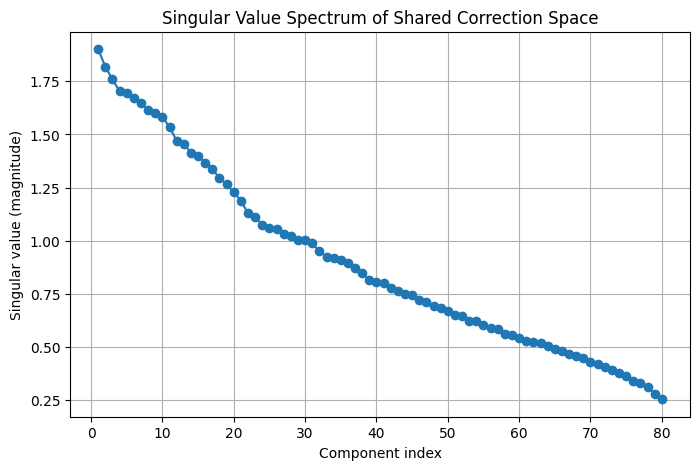

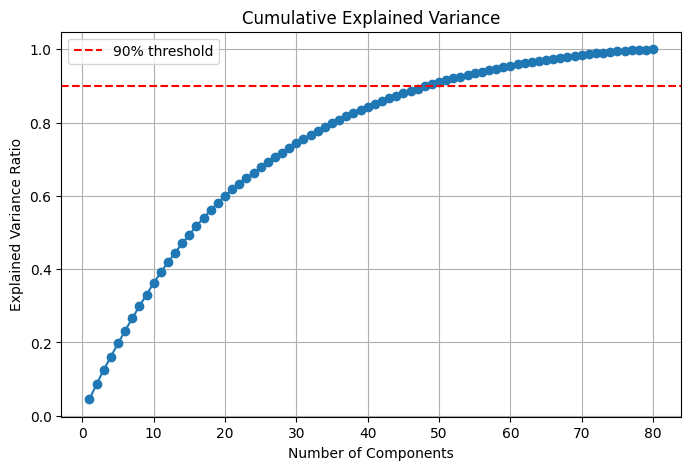

Component  1: Singular Value = 1.9005, Cumulative Explained Variance = 0.0451
Component  2: Singular Value = 1.8180, Cumulative Explained Variance = 0.0865
Component  3: Singular Value = 1.7581, Cumulative Explained Variance = 0.1251
Component  4: Singular Value = 1.7026, Cumulative Explained Variance = 0.1613
Component  5: Singular Value = 1.6939, Cumulative Explained Variance = 0.1972
Component  6: Singular Value = 1.6731, Cumulative Explained Variance = 0.2322
Component  7: Singular Value = 1.6454, Cumulative Explained Variance = 0.2660
Component  8: Singular Value = 1.6170, Cumulative Explained Variance = 0.2987
Component  9: Singular Value = 1.6015, Cumulative Explained Variance = 0.3308
Component 10: Singular Value = 1.5824, Cumulative Explained Variance = 0.3621
Component 11: Singular Value = 1.5338, Cumulative Explained Variance = 0.3915
Component 12: Singular Value = 1.4705, Cumulative Explained Variance = 0.4185
Component 13: Singular Value = 1.4567, Cumulative Explained Vari

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already done this earlier:
# all_bases = np.concatenate([rsv_dict[ds] for ds in datasets], axis=1)  # shape [D, 80]
U, S, Vh = np.linalg.svd(all_bases, full_matrices=False)

# Plot singular values (spectrum)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(S)+1), S, marker='o')
plt.title("Singular Value Spectrum of Shared Correction Space")
plt.xlabel("Component index")
plt.ylabel("Singular value (magnitude)")
plt.grid(True)
plt.show()

# Optional: Plot cumulative explained variance
explained_var = S**2
cumulative_var = np.cumsum(explained_var) / np.sum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(S)+1), cumulative_var, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% threshold")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.show()

# Print top few values numerically
for i, (sval, cum) in enumerate(zip(S[:20], cumulative_var[:20]), 1):
    print(f"Component {i:2d}: Singular Value = {sval:.4f}, Cumulative Explained Variance = {cum:.4f}")
